In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN, match_coord
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#
dr = 'dr9'
#survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
#reg = 'south'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s_%s_north_vs_south' %(dr, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

``` python
#
#patch = [100, 285, 29, 35]
patch = [200, 230, 29, 35]

cat_n = get_sweep_whole(patch=patch, dr=dr+'-north', rlimit=None, maskbitsource=False, bgsbits=True, opt='2', sweepdir='/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/north_vs_south/')
cat_s = get_sweep_whole(patch=patch, dr=dr+'-south', rlimit=None, maskbitsource=False, bgsbits=True, opt='2', sweepdir='/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/north_vs_south/')
```

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
cat_s = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/north_vs_south/dr9-south_sweep_200_230_29_35.npy')
cat_n = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/north_vs_south/dr9-north_sweep_200_230_29_35.npy')

# %time cat_s = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+'south'+'_100.0_285.0_29.0_35.0.npy')
# %time cat_s_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+'south'+'_100.0_285.0_29.0_35.0_n256.npy')

# %time cat_n = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+'north'+'_100.0_285.0_29.0_35.0.npy')
# %time cat_n_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+'north'+'_100.0_285.0_29.0_35.0_n256.npy')


In [4]:
#
def get_extra(cat):
    
    extra = Table()
    
    extra['hppix'] = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=True)
    print('healpix DONE...')
    c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
    extra['b'] = c.galactic.b.value # galb coordinate
    extra['l'] = c.galactic.l.value # galb coordinate
    print('galactic coordinates DONE...')
    
    regs = ['des', 'decals', 'north', 'desi', 'south']
    for i in regs:
        reg_ = get_reg(reg=i, hppix=extra['hppix'])
        extra[i] = reg_
        print(i, 'DONE...')
        
    return extra
    

In [5]:
#
cat_s_ex = get_extra(cat_s)
#np.save(savefile, tab)

healpix DONE...
galactic coordinates DONE...
des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...


In [6]:
cat_n_ex = get_extra(cat_n)

healpix DONE...
galactic coordinates DONE...
des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...


In [7]:
mask_s = (cat_s['DEC'] > 29) & (cat_s_ex['b'] > 0)
mask_n = (cat_n['DEC'] < 35) & (cat_n_ex['b'] > 0)

cat_s, cat_s_ex = cat_s[mask_s], cat_s_ex[mask_s]
cat_n, cat_n_ex = cat_n[mask_n], cat_n_ex[mask_n]

print(np.sum(mask_s), np.sum(mask_n))

9944996 6003760


In [8]:
%time ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
%time ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy')

CPU times: user 14.9 ms, sys: 37.6 s, total: 37.6 s
Wall time: 38.1 s
CPU times: user 0 ns, sys: 2min 36s, total: 2min 36s
Wall time: 2min 37s


In [9]:
mask_ran = (ran['DEC'] > 29) & (ran['DEC'] < 35) & (ran_ex['b'] > 0)
ran, ran_ex = ran[mask_ran], ran_ex[mask_ran]
rancuts = getGeoCuts(ran, randoms=True)

In [10]:
#match dr8_bass with dr8_decals 
idx2, idx1, d2d, d_ra, d_dec = match_coord(cat_n['RA'], cat_n['DEC'], cat_s['RA'], cat_s['DEC'], search_radius=0.5)


Doubly matched objects = 1111
Final matched objects = 4082499


mean: 0.122, 	 std: 0.107
3-sigma: 0.443 	 -0.200


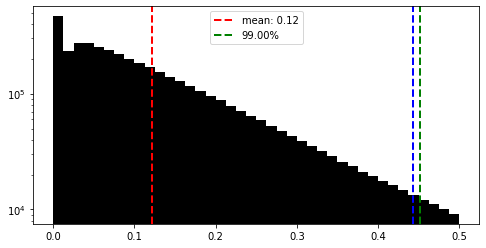

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(d2d, 40, log=True, color='k')

std1 = np.std(d2d)
mean = np.mean(d2d)

perc = 99.0
plt.axvline(mean, ls='--', c='r', lw=2, label='mean: %.2f' %(mean))
plt.axvline(mean+3*std1, ls='--', c='b', lw=2)
plt.axvline(np.percentile(d2d, perc), ls='--', c='g', lw=2, label='%.2f%%' %(perc))

print('mean: %.3f, \t std: %.3f' %(mean, std1))
print('3-sigma: %.3f \t %.3f' %(mean+3*std1, mean-3*std1))
plt.legend()

In [20]:
hpdict = {}

nside = 1024
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside,degrees=True)

#
hppix = hp.ang2pix(nside,(90.-np.array(tab['DEC_n']))*np.pi/180.,np.array(tab['RA_n'])*np.pi/180.,nest=True)
theta,phi  = hp.pix2ang(nside,np.arange(npix),nest=True)
hpdict['ra'],hpdict['dec'] = 180./np.pi*phi,90.-180./np.pi*theta
#get pixels ids within in north/south overlap
ind,c = np.unique(hppix[nobs],return_counts=True)

#pixels ids for randoms
hppix_ran = hp.ang2pix(nside,(90.-np.array(ran['DEC']))*np.pi/180.,np.array(ran['RA'])*np.pi/180.,nest=True)

#True if pixel is in north/south matched overlap footprint. 
#boolean with size of randoms
keep = np.in1d(hppix_ran, ind)

# computing fracareas
randdens = 5000*Nranfiles
print('randdens = ', randdens, ' ; len randoms = ', len(hppix_ran))
    
ind_ran, c_ran = np.unique(hppix_ran[keep],return_counts=True)
#fracarea for total randoms
hpdict['fracarea'] = np.zeros(npix)
hpdict['fracarea'][ind_ran] = c_ran / randdens / pixarea
print('fracarea DONE...')
#fracarea for reduced area (i.e., for BGS)
ind_ran, c_ran = np.unique(hppix_ran[(keep) & (rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])],return_counts=True)
hpdict['redfracarea'] = np.zeros(npix)
hpdict['redfracarea'][ind_ran] = c_ran / randdens / pixarea
print('redfracarea DONE...')

# areas
hpdict['area'] = hpdict['fracarea'].sum() * pixarea
hpdict['redarea'] = hpdict['redfracarea'].sum() * pixarea

print(hpdict['area'])
print(hpdict['redarea'])

randdens =  15000  ; len randoms =  13646102
fracarea DONE...
redfracarea DONE...


In [12]:
#
#get BGS flag in both:
bgs_bass = ((cat_n['BGSBITS'] & 2**(20)) != 0)
bgs_decals = ((cat_s['BGSBITS'] & 2**(20)) != 0)

bass_match = np.zeros_like(cat_n['DEC'], dtype=bool)
decals_match = np.zeros_like(cat_s['DEC'], dtype=bool)
bgsbassindecals = decals_match.copy()
bgsdecalsinbass = bass_match.copy()
decals_match[idx1] = True #flag for matches in dr8_decals
bass_match[idx2] = True #flag for matches in dr8_bass
bgsdecalsinbass[idx2] = bgs_decals[idx1] #bass flag of bgs in decals
bgsbassindecals[idx1] = bgs_bass[idx2] #decals flag of bgs in bass

print(np.sum(bass_match))
print(np.sum(decals_match))

tot = np.sum(bass_match)
totB = np.sum((bass_match) & (bgs_bass))
totD = np.sum((decals_match) & (bgs_decals))
#get bgs matched in each catalogue:
print('total matched: \t %i' %(tot))
print('\t & BGS_bass: \t %.2f %%' %(100*np.sum((bass_match) & (bgs_bass))/tot))
print('\t\t & BGS_bass & (BGS_decals): \t %.2f %%' %(100*np.sum((bass_match) & (bgs_bass) & (bgsdecalsinbass))/totB))
print('\t\t & BGS_bass & (~BGS_decals): \t %.2f %%' %(100*np.sum((bass_match) & (bgs_bass) & (~bgsdecalsinbass))/totB))
print('\t & BGS_decals: \t %.2f %%' %(100*np.sum((decals_match) & (bgs_decals))/tot))
print('\t\t & BGS_decals & (BGS_bass): \t %.2f %%' %(100*np.sum((decals_match) & (bgs_decals) & (bgsbassindecals))/totD))
print('\t\t & BGS_decals & (~BGS_bass): \t %.2f %%' %(100*np.sum((decals_match) & (bgs_decals) & (~bgsbassindecals))/totD))


4082499
4082499
total matched: 	 4082499
	 & BGS_bass: 	 1.84 %
		 & BGS_bass & (BGS_decals): 	 96.72 %
		 & BGS_bass & (~BGS_decals): 	 3.28 %
	 & BGS_decals: 	 3.67 %
		 & BGS_decals & (BGS_bass): 	 48.65 %
		 & BGS_decals & (~BGS_bass): 	 51.35 %


In [13]:
#Make a general catalogue containing the matched objects in north & south

tab = Table()

for key in cat_n.dtype.names:
    
    tab[key+'_n'] = cat_n[key][idx2]
    tab[key+'_s'] = cat_s[key][idx1]


In [12]:
''' python
savefile = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s/north_vs_south_match_0.5arcsec' %(dr, version)
np.save(savefile, tab)
#tab = np.load(savefile+'.npy')
'''

In [14]:
#completeness
nobs_n = (tab['NOBS_R_n'] > 0) & (tab['NOBS_G_n'] > 0) & (tab['NOBS_Z_n'] > 0)
nobs_s = (tab['NOBS_R_s'] > 0) & (tab['NOBS_G_s'] > 0) & (tab['NOBS_Z_s'] > 0)
nobs = (nobs_n) & (nobs_s)

In [15]:
#get stars and galaxies using our gaia classification
stars_n = ((tab['BGSBITS_n'] & 2**(6)) == 0)
stars_s = ((tab['BGSBITS_s'] & 2**(6)) == 0)
bgs_s = ((tab['BGSBITS_s'] & 2**(20)) != 0)
bgs_n = ((tab['BGSBITS_n'] & 2**(20)) != 0)
PSF_s = tab['TYPE_s'] == 'PSF '
PSF_n = tab['TYPE_n'] == 'PSF '
inGAIA_n = (tab['G_n'] != 0)
inGAIA_s = (tab['G_s'] != 0)

In [16]:
tot = len(tab)
tot_red = np.sum(nobs)
totB = np.sum((nobs) & (bgs_n))
totD = np.sum((nobs) & (bgs_s))
#get bgs matched in each catalogue:
print('total matched: \t %i' %(tot))
print('total matched with at least 1 obs in the 3 bands for both samples (tot complete): \t %i' %(tot_red))
print('------ Results below are restricted to nobs_{G,R,Z} > 0 in both, BASS/MzLS and DECaLS ------')
print('\t & BGS_bass: \t %.2f %%' %(100*np.sum((nobs) & (bgs_n))/tot_red))
print('\t\t & BGS_bass & (BGS_decals): \t %.2f %%' %(100*np.sum((nobs) & (bgs_n) & (bgs_s))/totB))
print('\t\t & BGS_bass & (~BGS_decals): \t %.2f %%' %(100*np.sum((nobs) & (bgs_n) & (~bgs_s))/totB))
print('\t & BGS_decals: \t %.2f %%' %(100*np.sum((nobs) & (bgs_s))/tot_red))
print('\t\t & BGS_decals & (BGS_bass): \t %.2f %%' %(100*np.sum((nobs) & (bgs_s) & (bgs_n))/totD))
print('\t\t & BGS_decals & (~BGS_bass): \t %.2f %%' %(100*np.sum((nobs) & (bgs_s) & (~bgs_n))/totD))

total matched: 	 4082499
total matched with at least 1 obs in the 3 bands for both samples (tot complete): 	 2780969
------ Results below are restricted to nobs_{G,R,Z} > 0 in both, BASS/MzLS and DECaLS ------
	 & BGS_bass: 	 2.64 %
		 & BGS_bass & (BGS_decals): 	 97.47 %
		 & BGS_bass & (~BGS_decals): 	 2.53 %
	 & BGS_decals: 	 2.72 %
		 & BGS_decals & (BGS_bass): 	 94.76 %
		 & BGS_decals & (~BGS_bass): 	 5.24 %


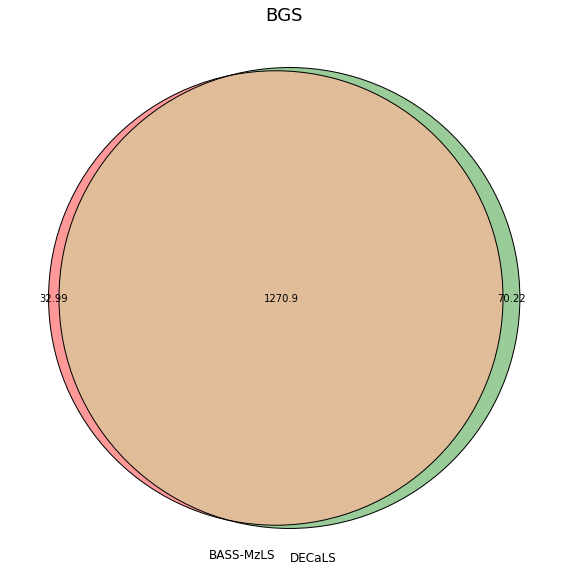

In [63]:
from QA import plot_venn2

A = (nobs) & (bgs_n)
B = (nobs) & (bgs_s)
plot_venn2(A,B,hpdict['redarea'], title='BGS', labels=['BASS-MzLS', 'DECaLS'], savefile=None)

In [67]:
#
bgsdict = {'BGS both':(nobs) & (bgs_n) & (bgs_s), 'BGS DECaLS only':(nobs) & (~bgs_n) & (bgs_s), 'BGS BASS/MzLS only':(nobs) & (bgs_n) & (~bgs_s)}

for num, (key, val) in enumerate(bgsdict.items()):
    print(num, key, np.sum(val)/hpdict['redarea'])

0 BGS both 1270.900418540715
1 BGS DECaLS only 70.21617900009228
2 BGS BASS/MzLS only 32.987585736965265


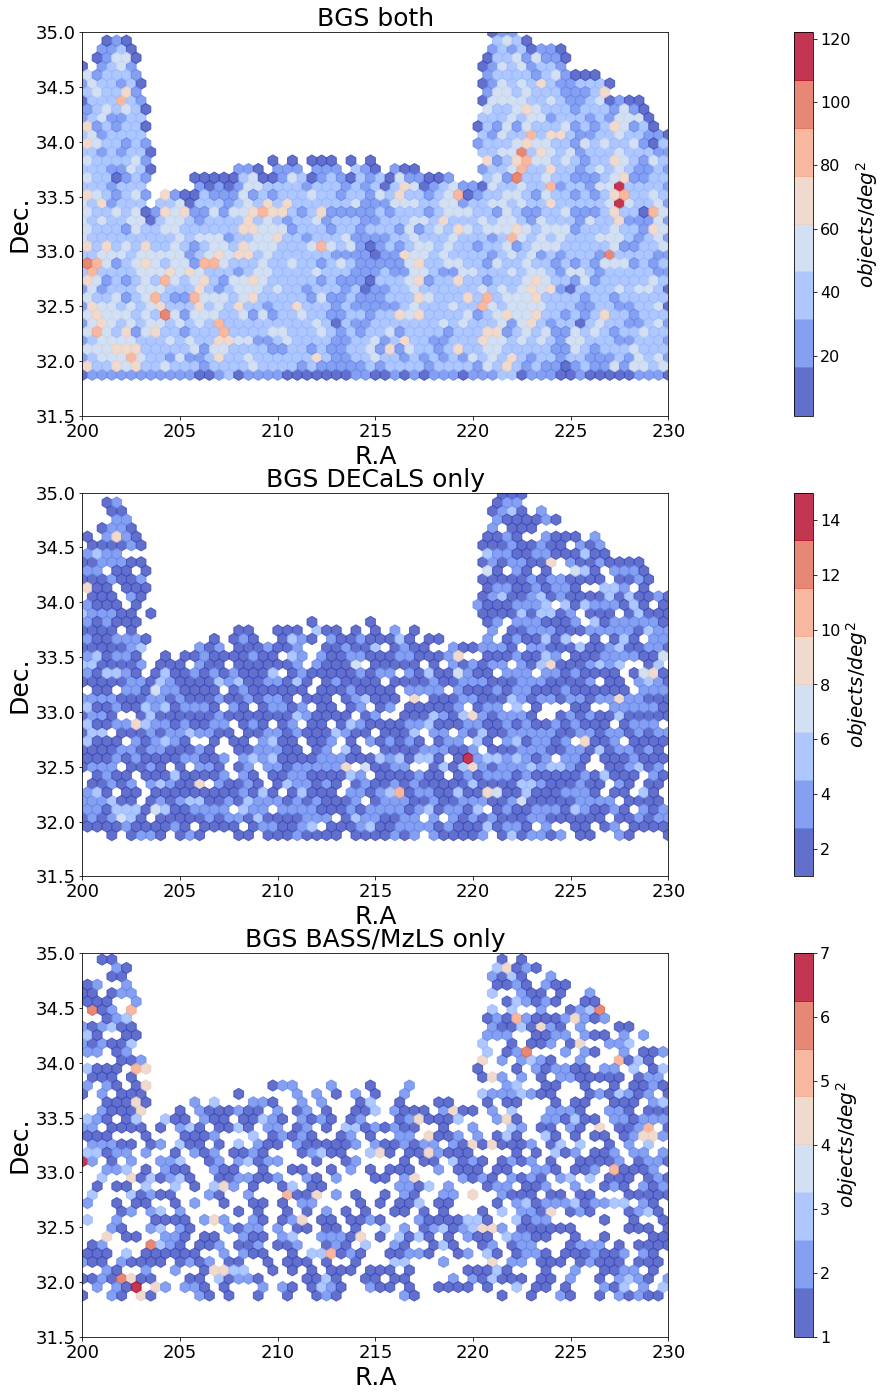

In [77]:
#
rows, cols = 3, 1
fig    = plt.figure(figsize=(15*cols,8*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
ax = fig.add_subplot(gs[0])
cmap = plt.get_cmap('coolwarm', 8)
Ared = hpdict['redarea']
#xlim0 = 100

for num, (key, val) in enumerate(bgsdict.items()):
    
    #mask = (tab['RMAG_s'] < 22)
    ax = hexbin(coord={'R.A':tab['RA_s'], 'Dec.':tab['DEC_s']}, C=None, clab='$objects/deg^{2}$', catmask=(val), n=num, bins=None, title=key, cmap=cmap, 
               ylab=True, xlab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=pathdir+'/agreements_disagreements_%s' %(i), fracs=False, area=Ared, cbar='vertical', xlim=[200, 230], ylim=[31.5, 35], 
                       showmedian=False, gridsize=(np.int(120*0.5),np.int(40*0.5)))
    
    
#      ax = hexbin(coord=coord, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=num, bins='log', title=key, cmap=cmap, 
#                ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 4), ylim=(-2, 4), 
#                    vmin=None, vmax=8, mincnt=1, fmcline=False,
#                        file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)
        
        

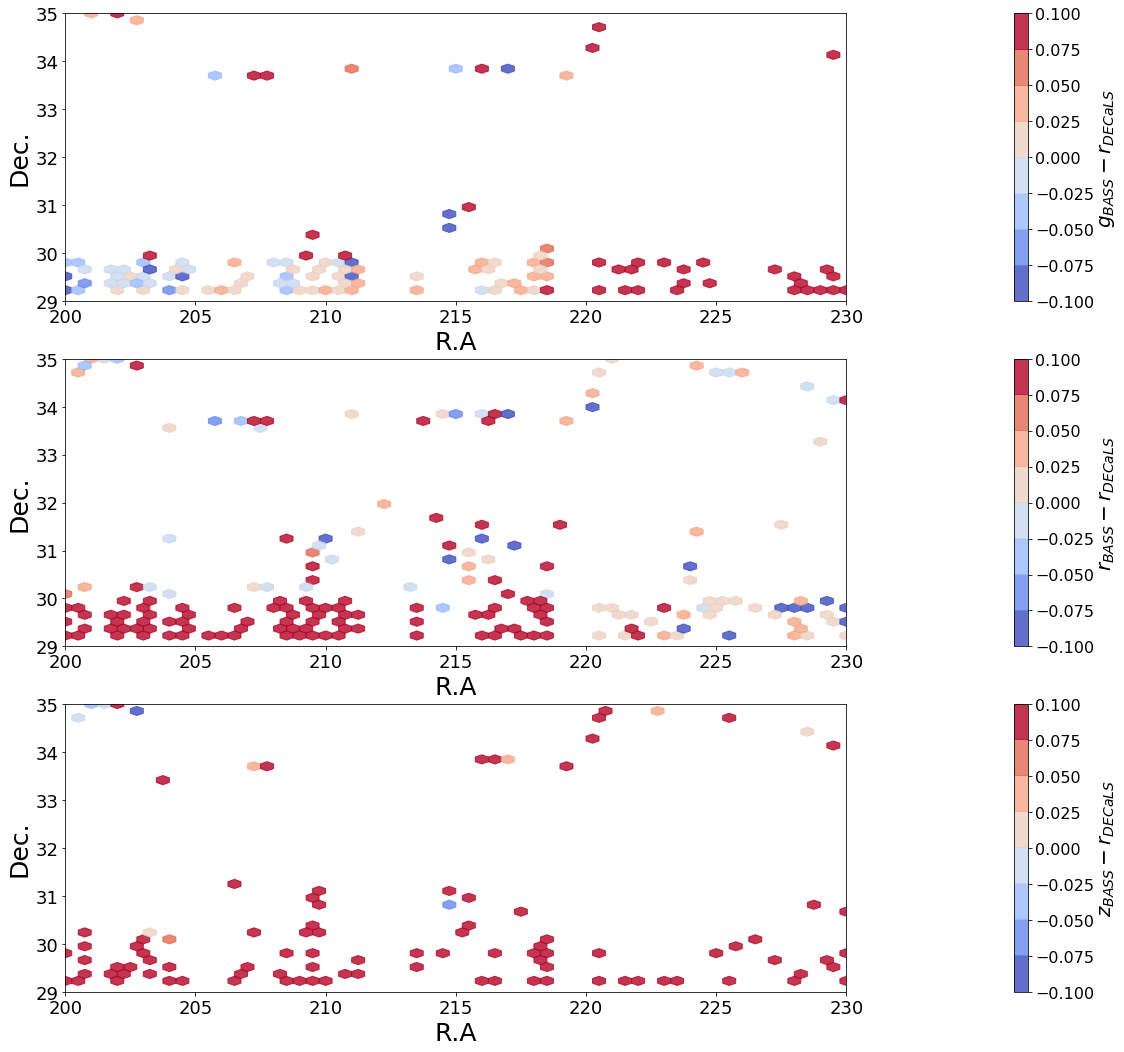

In [98]:
#

rows, cols = 3, 1
fig    = plt.figure(figsize=(20*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
ax = fig.add_subplot(gs[0])
cmap = plt.get_cmap('coolwarm', 8)
#xlim0 = 100

for num,i in enumerate(['G', 'R', 'Z']):
    mask = (tab['RMAG_s'] < 25)
    #tab['NOBS_%s_s' %(i)]
    hexbin(coord={'R.A':tab['RA_s'], 'Dec.':tab['DEC_s']}, C=tab['%sMAG_n' %(i)]-tab['%sMAG_s' %(i)], catmask=(mask), n=num, bins=None, title=None, cmap=cmap, 
               ylab=True, xlab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=None, 
                   file=pathdir+'/south_NOBS_%s_matches_r<22' %(i), fracs=False, area=None, cbar='vertical', xlim=[200, 230], ylim=[29, 35], 
                       showmedian=False, clab=r'$%s_{BASS}-r_{DECaLS}$' %(i.lower()), gridsize=(np.int(120*0.5),np.int(40*0.5)))
    
# ranges = [0, 60, 120, 180]
# for i in range(len(ranges[:-1])):
#     mask = (tab['RMAG_s'] < 22)
#     hexbin(coord={'R.A':tab['RA_s'], 'Dec.':tab['DEC_s']}, C=tab['NOBS_Z_s'], catmask=(mask), n=i, bins=None, title=None, cmap=cmap, 
#                ylab=True, xlab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=0, vmax=2, mincnt=None, 
#                    file=pathdir+'/south_NOBS_Z_matches_r<22', fracs=False, area=None, cbar='horizontal', xlim=[xlim0+ranges[i], xlim0+ranges[i+1]], ylim=[29, 35], 
#                        showmedian=False, clab=r'$NOBS_{Z}$', gridsize=(120,40))


In [24]:
set(tab['TYPE_n'])

{'DEV', 'DUP', 'EXP', 'PSF', 'REX', 'SER'}

GENERAL: median = -0.0254, mean = -0.028
	 REX: median = -0.0428, mean = -0.0629, f=0.486
	 EXP: median = -0.0353, mean = -0.049, f=0.103
	 DEV: median = -0.134, mean = -0.191, f=0.040
	 SER: median = -0.0219, mean = -0.0326, f=0.020
	 PSF: median = -0.000216, mean = 0.0453, f=0.351


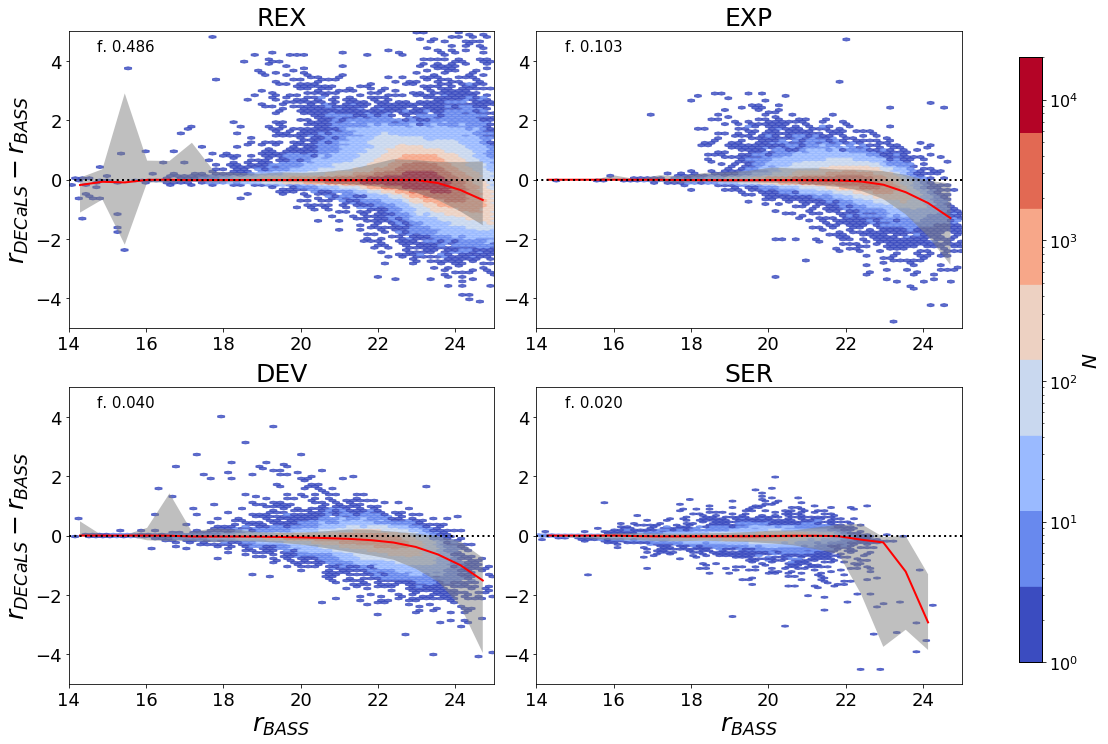

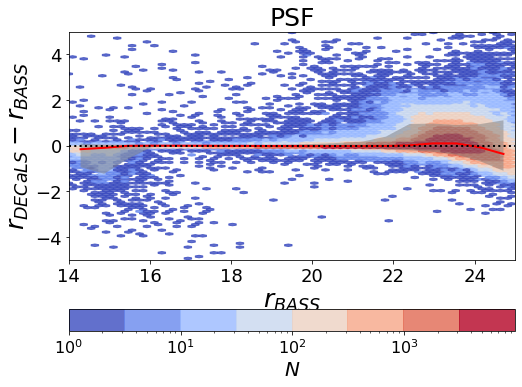

In [18]:
#
coord = {
    '$r_{BASS}$':tab['RMAG_n'],
    '$r_{DECaLS}-r_{BASS}$':(tab['RMAG_s'] - tab['RMAG_n']) 
    }
#morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
morphos = ['REX', 'EXP', 'DEV', 'SER']
keys = list(coord.keys())
infs = (np.isfinite(coord[keys[0]])) & ((np.isfinite(coord[keys[1]])))
rows, cols = 2, 2
#debug = cat['RMAG'] < 16
mask = (infs) & (nobs)
hline, vline = None, None
vmin, vmax = 1, None

xlim=[14, 25]
ylim=[-5, 5]
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)

tot = np.sum(mask)
print('GENERAL: median = %2.3g, mean = %2.3g' %(np.median(coord[keys[1]][mask]), np.mean(coord[keys[1]][mask])))
    
for i, morpho in enumerate(morphos):
    
    ax = fig.add_subplot(gs[i])
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == 'PSF': 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 20000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
    cmap = plt.get_cmap('coolwarm', 8)
        
    morphomask = tab['TYPE_s'] == morpho
    f = np.sum((mask) & (morphomask))/tot
    print('\t %s: median = %2.3g, mean = %2.3g, f=%.3f' 
          %(morpho, np.median(coord[keys[1]][(mask) & (morphomask)]), np.mean(coord[keys[1]][(mask) & (morphomask)]), f))
    
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap=cmap, 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file=pathdir+'/rmag_diff', fracs=False, area=None, cbar=cbar, xlim=xlim, ylim=ylim, showmedian=True)
    
    ax.axhline(0, ls=':', lw=2, color='k')
    #write out fraction
    dx = np.abs(xlim[1] - xlim[0])/15.
    dy = np.abs(ylim[1] - ylim[0])/15.
    ax.text(xlim[0]+dx, ylim[1]-dy, r'f. %.3f' %(f), size=15)

morpho = 'PSF'
rows, cols = 1, 1
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
ax = fig.add_subplot(gs[0])
cmap = plt.get_cmap('coolwarm', 8)
morphomask = tab['TYPE_s'] == morpho
f = np.sum((mask) & (morphomask))/tot
print('\t %s: median = %2.3g, mean = %2.3g, f=%.3f' 
          %(morpho, np.median(coord[keys[1]][(mask) & (morphomask)]), np.mean(coord[keys[1]][(mask) & (morphomask)]), f))
    
hexbin(coord=coord, catmask=((mask) & (morphomask)), n=0, bins='log', title=morpho, cmap=cmap, 
               ylab=True, xlab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=1, vmax=None, mincnt=1, 
                   file=pathdir+'/rmag_diff_psf', fracs=False, area=None, cbar='horizontal', xlim=xlim, ylim=ylim, showmedian=True)
ax.axhline(0, ls=':', lw=2, color='k')


In [100]:
pathdir

'/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9_0.1.0_north_vs_south'

===== x:$r_{DECaLS}$ 	 y:$r_{BASS}-r_{DECaLS}$ ===== 
stars in both: median = 0.0167, mean = 0.0239, x(3%):14.1955, x(97%):21.3174
$r_{BASS}$ at $r_{DECaLS} = 20.0$: \t 20.018
BGS in both: median = 0.0236, mean = 0.0282, x(3%):16.8894, x(97%):19.9379


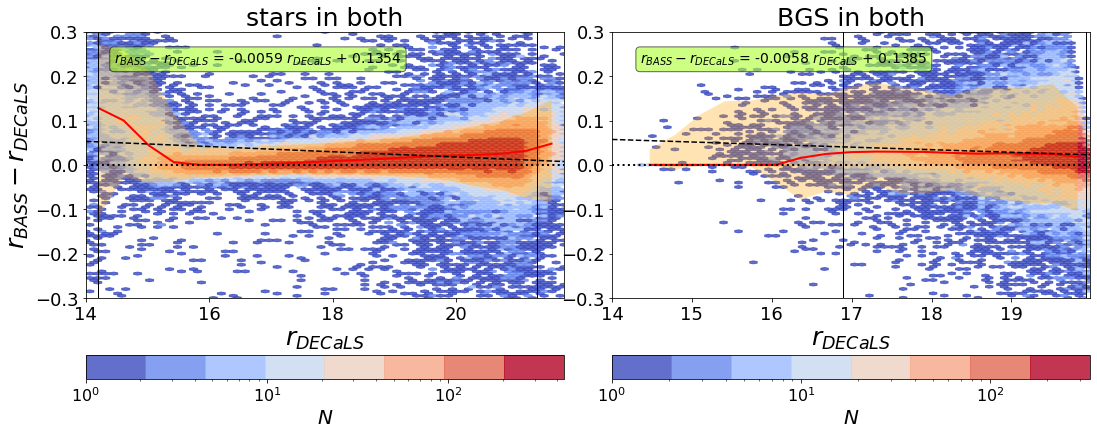

===== x:$(g-r)_{DECaLS}$ 	 y:$r_{BASS}-r_{DECaLS}$ ===== 
stars in both: median = 0.0167, mean = 0.0245, x(3%):0.2343, x(97%):1.5433
$r_{BASS}$ at $r_{DECaLS} = 20.0$ and at $g-r(min) = 0.23$: \t 20.005
$r_{BASS}$ at $r_{DECaLS} = 20.0$ and at $g-r(max) = 1.54$: \t 20.040
BGS in both: median = 0.0231, mean = 0.0276, x(3%):0.3730, x(97%):1.7534


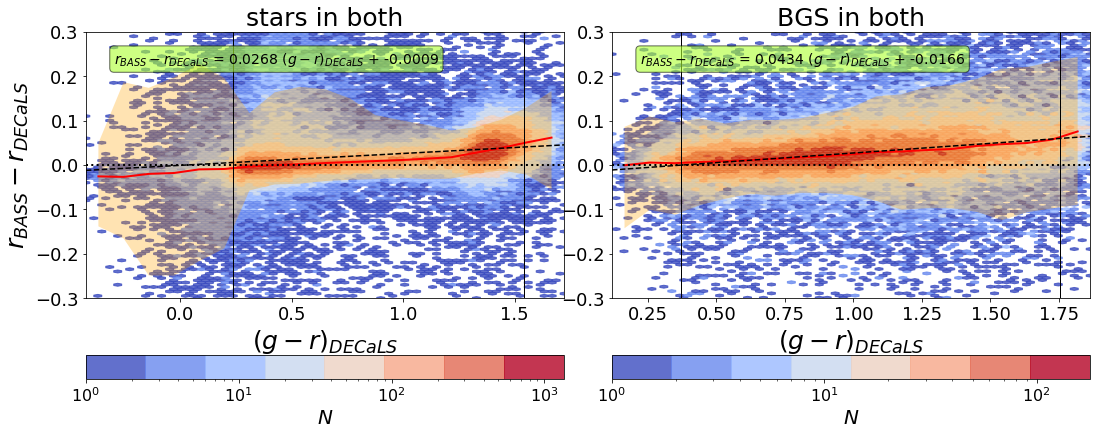

===== x:$(r-z)_{DECaLS}$ 	 y:$r_{BASS}-r_{DECaLS}$ ===== 
stars in both: median = 0.0166, mean = 0.0239, x(3%):-0.0532, x(97%):2.1758
BGS in both: median = 0.0232, mean = 0.0275, x(3%):0.2247, x(97%):0.9542


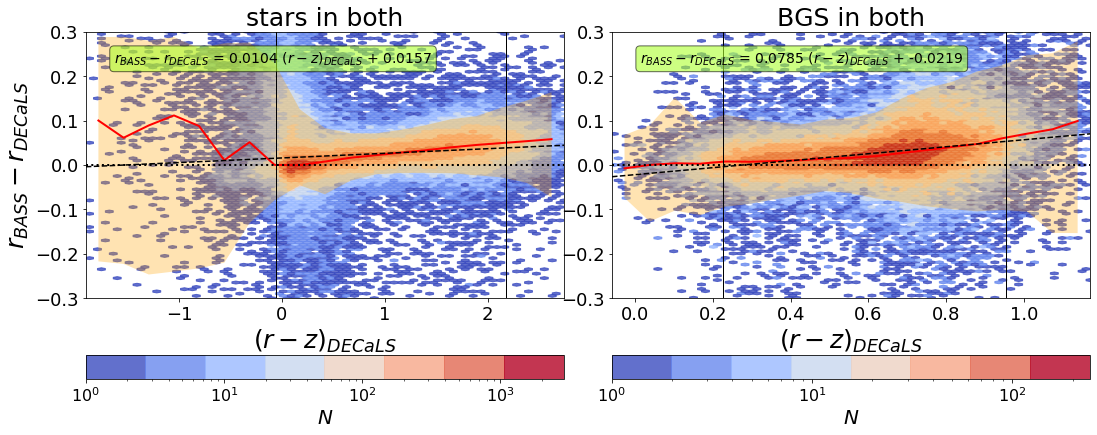

===== x:$(g-z)_{DECaLS}$ 	 y:$r_{BASS}-r_{DECaLS}$ ===== 
stars in both: median = 0.0167, mean = 0.0241, x(3%):0.2336, x(97%):3.6895
BGS in both: median = 0.0231, mean = 0.0275, x(3%):0.6062, x(97%):2.6794


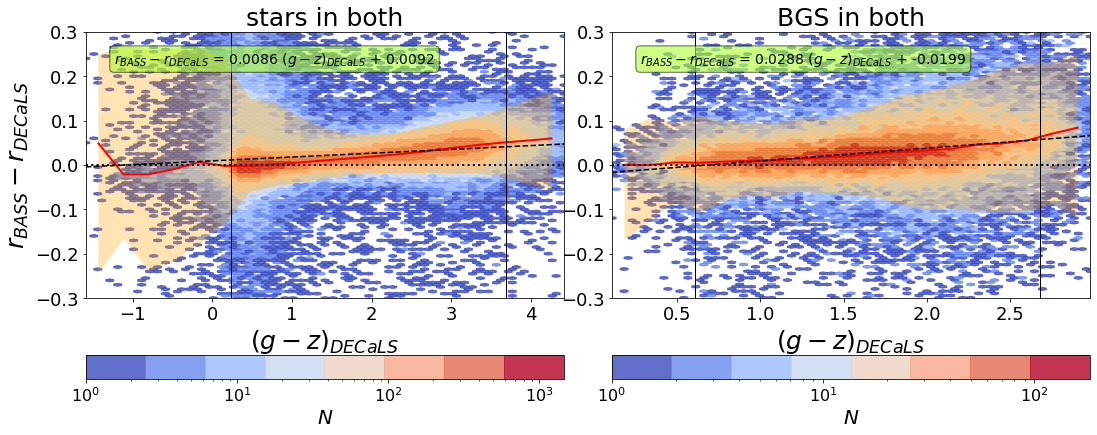

In [99]:
#
coords = [
    {
    '$r_{DECaLS}$':(tab['RMAG_s']),
    '$r_{BASS}-r_{DECaLS}$':(tab['RMAG_n'] - tab['RMAG_s']) 
    },
    {
    '$(g-r)_{DECaLS}$':(tab['GMAG_s'] - tab['RMAG_s']),
    '$r_{BASS}-r_{DECaLS}$':(tab['RMAG_n'] - tab['RMAG_s']) 
    },
#     {
#     '$(G-rr)_{DECaLS}$':(tab['G_s'] - 22.5 + 2.5*np.log10(tab['FLUX_R_s'])),
#     '$(G-rr)_{BASS}-(G-rr)_{DECaLS}$':((tab['G_n'] - 22.5 + 2.5*np.log10(tab['FLUX_R_n'])) - (tab['G_s'] - 22.5 + 2.5*np.log10(tab['FLUX_R_s']))) 
#     },
#     {
#     '$FM_{R,DECaLS}$':tab['FRACMASKED_R_s'],
#     '$FM_{R,BASS}$ - $FM_{R,DECaLS}$':(tab['FRACMASKED_R_n'] - tab['FRACMASKED_R_s']) 
#     },
#     {
#     '$FM_{G,DECaLS}$':tab['FRACMASKED_G_s'],
#     '$FM_{G,BASS}$ - $FM_{G,DECaLS}$':(tab['FRACMASKED_G_n'] - tab['FRACMASKED_G_s']) 
#     },
#     {
#     '$FM_{Z,DECaLS}$':tab['FRACMASKED_Z_s'],
#     '$FM_{Z,BASS}$ - $FM_{Z,DECaLS}$':(tab['FRACMASKED_Z_n'] - tab['FRACMASKED_Z_s']) 
#     },
#     {
#     '$FF_{R,DECaLS}$':tab['FRACFLUX_R_s'],
#     '$FF_{R,BASS}$ - $FF_{R,DECaLS}$':(tab['FRACFLUX_R_n'] - tab['FRACFLUX_R_s']) 
#     },
#     {
#     '$FF_{G,DECaLS}$':tab['FRACFLUX_G_s'],
#     '$FF_{G,BASS}$ - $FF_{G,DECaLS}$':(tab['FRACFLUX_G_n'] - tab['FRACFLUX_G_s']) 
#     },
#     {
#     '$FF_{Z,DECaLS}$':tab['FRACFLUX_Z_s'],
#     '$FF_{Z,BASS}$ - $FF_{Z,DECaLS}$':(tab['FRACFLUX_Z_n'] - tab['FRACFLUX_Z_s']) 
#     },
    {
    '$(r-z)_{DECaLS}$':(tab['RMAG_s'] - tab['ZMAG_s']),
    '$r_{BASS}-r_{DECaLS}$':(tab['RMAG_n'] - tab['RMAG_s']) 
    },
    {
    '$(g-z)_{DECaLS}$':(tab['GMAG_s'] - tab['ZMAG_s']),
    '$r_{BASS}-r_{DECaLS}$':(tab['RMAG_n'] - tab['RMAG_s']) 
    }
#     {
#     '$(g-r)_{DECaLS}$':(tab['GMAG_s'] - tab['RMAG_s']),
#     '$(g-r)_{BASS}$':(tab['GMAG_n'] - tab['RMAG_n']) 
#     },
#     {
#     '$(r-z)_{DECaLS}$':(tab['RMAG_s'] - tab['ZMAG_s']),
#     '$(r-z)_{BASS/MzLS}$':(tab['RMAG_n'] - tab['ZMAG_n']) 
#     },
#     {
#     '$(g-z)_{DECaLS}$':(tab['GMAG_s'] - tab['ZMAG_s']),
#     '$(g-z)_{BASS/MzLS}$':(tab['GMAG_n'] - tab['ZMAG_n']) 
#     }
    ]

fit_dict = {}


for num, coord in enumerate(coords):
    
    keys = list(coord.keys())
    #remove infs
    infs = (np.isfinite(coord[keys[0]])) & ((np.isfinite(coord[keys[1]])))
    #mask = (coord[keys[0]] > 0) & (coord[keys[0]] < 1.5) & (~inGAIA_n) & (~inGAIA_s)
    catmask = {'stars in both':(stars_n) & (stars_s) & (infs) & (nobs), 'BGS in both':(bgs_n) & (bgs_s) & (infs) & (nobs)}
    #catmask = {'stars in both':(PSF_n) & (PSF_s) & (infs) & (mask), 'galaxies in both':(~PSF_n) & (~PSF_s) & (infs) & (mask)}

    if keys[0] == '$r_{DECaLS}$': xlim = [14, 25]
    else: xlim=[-3, 5]
    #xlim=[0, 1.5]
    ylim=[-0.3, 0.3]

    rows, cols = 1, 2
    fig    = plt.figure(figsize=(9*cols,7*rows))
    gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
    cmap = plt.get_cmap('coolwarm', 8)
    
    print('===== x:%s \t y:%s ===== ' %(keys[0], keys[1]))

    for i, key, val in zip([0,1], catmask.keys(), catmask.values()):
        ax = fig.add_subplot(gs[i])
        x, y = coord[keys[0]], coord[keys[1]]
        
        if keys[0] == '$(G-rr)_{DECaLS}$': 
            val = (val) & (tab['G_n'] != 0) & (tab['G_s'] != 0)
            ax.axvline(0.6, ls='-', lw=4, color='green', alpha=0.4)
        
        clipped = True
        if clipped:
            clipx = np.percentile(x[val], (0.1,99.5))
            clipy = np.percentile(y[val], (.1,99.5))
            clipmask = (x > clipx[0]) & (x < clipx[1]) & (y > clipy[0]) & (y < clipy[1])
            #x, y = x[clipmask], y[clipmask]
            val = (val) & (clipmask)
            xlim = clipx
            if keys[0] == '$r_{DECaLS}$': xlim = [14, xlim[1]]
                
        xmin, xmax = np.percentile(x[val], (3, 97))
        
        print('%s: median = %.4f, mean = %.4f, x(3%%):%.4f, x(97%%):%.4f' 
              %(key, np.median(y[val]), np.mean(y[val]), xmin, xmax))
    
        hexbin(coord=coord, catmask=val, n=i, bins='log', title=key, cmap=cmap, 
               ylab=(i == 0), xlab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=1, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, 
                       cbar='horizontal', xlim=xlim, ylim=ylim, showmedian=True)
    
        ax.axhline(0, ls=':', lw=2, color='k')
        ax.axvline(xmin, ls='-', lw=1, color='k', alpha=1)
        ax.axvline(xmax, ls='-', lw=1, color='k', alpha=1)
    
        #best-fit
        z = np.polyfit(x[val], y[val], 1)
        p = np.poly1d(z)
        xfit = np.linspace(xlim[0], xlim[1], 30)
        ax.plot(xfit, p(xfit), '--', lw=1.5, color='k')
        #write out best-fit parameters
        dx = np.abs(xlim[1] - xlim[0])/17.
        dy = np.abs(ylim[1] - ylim[0])/17.
        props = dict(boxstyle='round', facecolor='greenyellow', alpha=0.7)
        
        fit = r'%s = %.4f %s + %.4f' %(keys[1], z[0], keys[0], z[1])
        fit_dict[key.split(' ')[0]+'_'+str(num)] = fit
        ax.text(xlim[0]+dx, ylim[1]-2*dy, fit, size=14, bbox=props)
        
        # get r_bass at r_decals = 20 with current best fit for stars
        if (num == 0) and (i == 0):
            r_decals = 20
            r_bass = z[0] * r_decals + z[1] + r_decals
            print(r'$r_{BASS}$ at $r_{DECaLS} = %.1f$: \t %.3f' %(r_decals, r_bass))
            
        # get r-bass MIN() and MAX() with g-r colour best fit with stars
        if (num == 1) and (i == 0):
            r_decals = 20
            g_r_min = xmin
            g_r_max = xmax
            r_bass_min = z[0] * g_r_min + z[1] + r_decals
            r_bass_max = z[0] * g_r_max + z[1] + r_decals
            print(r'$r_{BASS}$ at $r_{DECaLS} = %.1f$ and at $g-r(min) = %.2f$: \t %.3f' %(r_decals, g_r_min, r_bass_min))
            print(r'$r_{BASS}$ at $r_{DECaLS} = %.1f$ and at $g-r(max) = %.2f$: \t %.3f' %(r_decals, g_r_max, r_bass_max))
        
    file=pathdir+'/photometry_%i' %(num)
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
# #x(3%):0.3739, x(97%):1.7755
# Rb = -0.01*20+0.2166+20
# Rbmin = 0.0005*(0.3739)+0.0376+20
# Rbmax = 0.0005*(1.7755)+0.0192+20
# print(Rb, Rbmin, Rbmax)
    

In [95]:
for key, val in fit_dict.items():
    if key.split('_')[0] == 'stars':
        print(val)

$r_{BASS}-r_{DECaLS}$ = -0.0059 $r_{DECaLS}$ + 0.1354
$r_{BASS}-r_{DECaLS}$ = 0.0268 $(g-r)_{DECaLS}$ + -0.0009
$r_{BASS}-r_{DECaLS}$ = 0.0104 $(r-z)_{DECaLS}$ + 0.0157
$r_{BASS}-r_{DECaLS}$ = 0.0086 $(g-z)_{DECaLS}$ + 0.0092


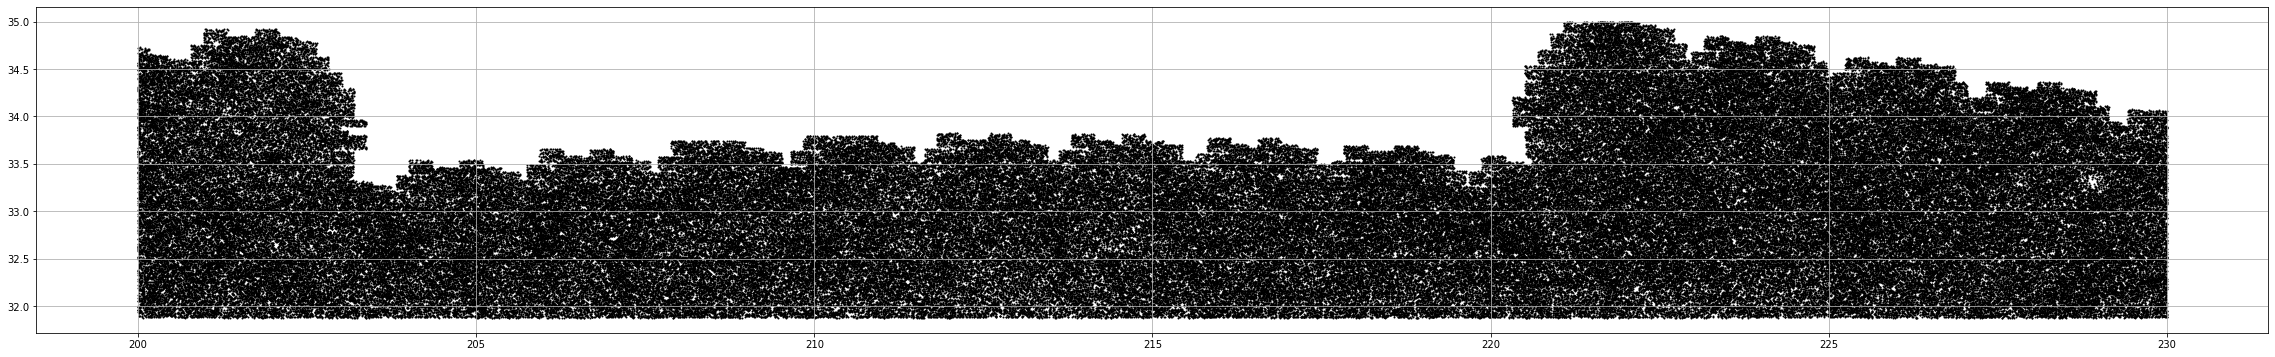

In [23]:
plt.figure(figsize=(40, 6))
plt.scatter(tab['RA_s'][nobs][::10], tab['DEC_s'][nobs][::10], c='k', s=1)
#plt.scatter(hpdict['ra'][ind], hpdict['dec'][ind], c='r', s=5)

#plt.xlim(250, 255)
#plt.ylim(30,32)
plt.grid()

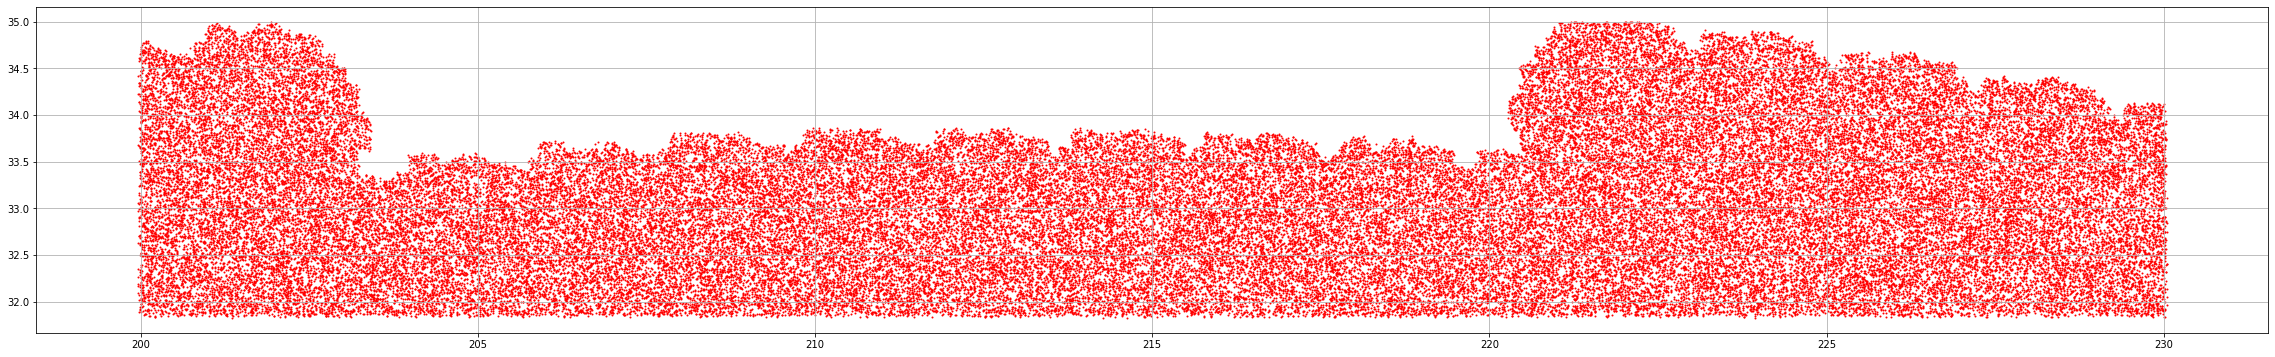

In [24]:
plt.figure(figsize=(40, 6))
plt.scatter(ran['RA'][keep][::10], ran['DEC'][keep][::10], c='r', s=1)
plt.grid()

In [25]:
#get BGS in north/south but without rmag limit at 20
bgs21_n = bgsbut(bgsbits=tab['BGSBITS_n'], rmag=tab['RMAG_n'], pop=None, bgsmask=bgsmask(), rlimit=21)
bgs21_s = bgsbut(bgsbits=tab['BGSBITS_s'], rmag=tab['RMAG_s'], pop=None, bgsmask=bgsmask(), rlimit=21)

In [26]:
print('BGS DECaLS density: \t %.3f' %(np.sum(bgs_s & nobs)/hpdict['redarea']))
print('BGS BASS/MzLS density: \t %.3f' %(np.sum(bgs_n & nobs)/hpdict['redarea']))

BGS DECaLS density: 	 1341.117
BGS BASS/MzLS density: 	 1303.888


(800, 1450)

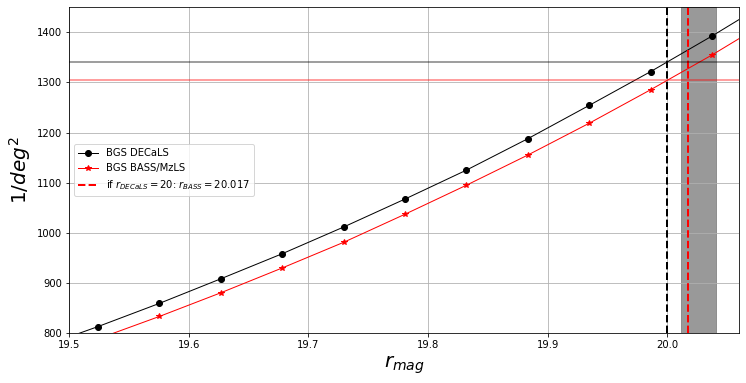

In [31]:
plt.figure(figsize=(12, 6))

bins = np.linspace(0, 20.5, 400)
x1, bins0 = np.histogram(tab['RMAG_s'][bgs21_s & nobs], bins=bins, weights=np.full_like(tab['RMAG_s'][bgs21_s & nobs],1./ hpdict['redarea']))
#plt.hist(tab['RMAG_s'][bgs21_s & nobs], bins=bins, cumulative=True, weights=np.full_like(tab['RMAG_s'][bgs21_s & nobs],1./ hpdict['redarea']), 
#         lw=2, histtype='step', color='k', label=r'BGS DECaLS')
x2, bins0 = np.histogram(tab['RMAG_n'][bgs21_n & nobs], bins=bins, weights=np.full_like(tab['RMAG_n'][bgs21_n & nobs],1./ hpdict['redarea']))
#plt.hist(tab['RMAG_n'][bgs21_n & nobs], bins=bins, cumulative=True, weights=np.full_like(tab['RMAG_n'][bgs21_n & nobs],1./ hpdict['redarea']), 
#         lw=2, histtype='step', color='r', label=r'BGS BASS/MzLS')
#delta = (bins0[1]-bins0[0])/2

plt.plot(bins0[1:], np.cumsum(x1), marker='o', c='k', label=r'BGS DECaLS', lw=1)
plt.plot(bins0[1:], np.cumsum(x2), marker='*', c='r', label=r'BGS BASS/MzLS', lw=1)

plt.axvline(20, lw=2, ls='--', color='k')
#Rb = 20.0352
plt.axvline(r_bass, lw=2, ls='--', color='r', label=r'if $r_{DECaLS}=20$: $r_{BASS}=%.3f$' %(r_bass))
plt.axhline((np.sum(bgs_s & nobs)/hpdict['redarea']), c='k', ls='-', alpha=0.5)
plt.axhline((np.sum(bgs_n & nobs)/hpdict['redarea']), c='r', ls='-', alpha=0.5)
plt.axvspan(r_bass_min, r_bass_max, alpha=0.8, color='gray')

plt.xlabel(r'$r_{mag}$', size=20)
plt.ylabel(r'$1/deg^2$', size=20)

plt.legend()
plt.grid()
plt.xlim(19.5,20.06)
plt.ylim(800, 1450)


### What if we extend the rmag limit for BGS in BASS/MzLS?

In [44]:
#
key = 'BGS in DECaLS but not BGS in BASS/MzLS [1/sq.deg]'
decals_nominal = (bgs_s) & (~bgs_n) & (nobs)
decals_ext = (bgs_s) & ~((bgs21_n) & (tab['RMAG_n'] < r_bass)) & (nobs)
decals_diff = (decals_nominal) & (~decals_ext)

bass_nominal = (bgs21_n) & (tab['RMAG_n'] < 20) & (nobs)
bass_ext = (bgs21_n) & (tab['RMAG_n'] < r_bass) & (nobs)
bass_diff = (bass_ext) & (~bass_nominal)

print('BGS BASS/MzLS density [1/sq.deg]: \t %.3f(NOMINAL) \t %.3f(EXT) \t %.3f(DIFF)' 
      %(np.sum(bass_nominal)/hpdict['redarea'],
       np.sum(bass_ext)/hpdict['redarea'],
       np.sum(bass_diff)/hpdict['redarea']))

print('%s: \t %.3f(NOMINAL) \t %.3f(EXT) \t %.3f(DIFF)' 
      %(key, np.sum(decals_nominal)/hpdict['redarea'],
       np.sum(decals_ext)/hpdict['redarea'],
       np.sum(decals_diff)/hpdict['redarea']))


BGS BASS/MzLS density [1/sq.deg]: 	 1303.888(NOMINAL) 	 1326.850(EXT) 	 22.962(DIFF)
BGS in DECaLS but not BGS in BASS/MzLS [1/sq.deg]: 	 70.216(NOMINAL) 	 56.145(EXT) 	 14.072(DIFF)


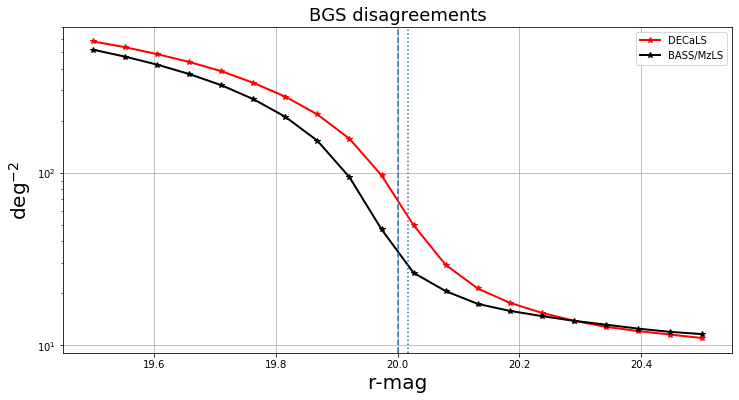

In [61]:
#
plt.figure(figsize=(12,6))

rbins = np.linspace(19.5, 20.5, 20)

res = []

for i in rbins:
    
    decals = (bgs_s) & ~((bgs21_n) & (tab['RMAG_n'] < i)) & (nobs)
    bass = (bgs_n) & ~((bgs21_s) & (tab['RMAG_s'] < i)) & (nobs)
    res.append([i, np.sum(decals)/hpdict['redarea'], np.sum(bass)/hpdict['redarea']])

res = np.transpose(res)   

plt.plot(res[0], res[1], marker='*', lw=2, c='r', label='DECaLS')
plt.plot(res[0], res[2], marker='*', lw=2, c='k', label='BASS/MzLS')
plt.axvline(20, ls='--')
plt.axvline(r_bass, ls=':')
plt.grid()

plt.title('BGS disagreements', size=18)
plt.xlabel(r'r-mag', size=20)
plt.ylabel(r'deg$^{-2}$', size=20)
plt.legend()
plt.yscale('log')



In [62]:
np.transpose(res)[2]

array([ 19.60526316, 487.18352147, 423.44419497])

### Why do we have such a big difference between BGS in BASS/MzLS and BGS in DECaLS?

In [35]:
Grr_s = tab['G_s'] - 22.5 + 2.5*np.log10(tab['FLUX_R_s'])
Grr_n = tab['G_n'] - 22.5 + 2.5*np.log10(tab['FLUX_R_n'])

In [36]:
#
keep = {'BGS in DECaLS but not BGS in BASS/MzLS':(bgs_s) & (~bgs_n) & (nobs), 
        'BGS in BASS/MzLS but not BGS in DECaLS':(~bgs_s) & (bgs_n) & (nobs)}

for num, key, val in zip([0, 1],keep.keys(), keep.values()):
    
    print('========== %s (%.3f [1/sq.deg]) ==========' %(key, np.sum(val)/hpdict['redarea']))
    
    for i in set(tab['TYPE_n'][:10000]):
        morph_n = np.sum((tab['TYPE_n'] == i) & (val))/hpdict['redarea']
        morph_s = np.sum((tab['TYPE_s'] == i) & (val))/hpdict['redarea']
        print('%s: \t %.3f(north) \t %.3f(south)' %(i, morph_n, morph_s))

    if num == 0: 
        bgsbits = tab['BGSBITS_n']
        rmag = tab['RMAG_n']
        print('WHY NOT BGS in BASS/MzLS?')
    if num == 1: 
        bgsbits = tab['BGSBITS_s']
        rmag = tab['RMAG_s']
        print('WHY NOT BGS in DECaLS?')
        
    bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    for i in bgslist:
        mask = ((bgsbits & 2**(bgsmask()[i])) == 0) & (val) & (rmag<20)
        print('reject by %s & rmag < 20: \t %.4f' % (i, np.sum(mask)/hpdict['redarea']))
    print('reject by rmag > 20: \t %.4f' % (np.sum((val) & (rmag>20))/hpdict['redarea']))
    
    

========== BGS in DECaLS but not BGS in BASS/MzLS (70.216 [1/sq.deg]) ==========
SER: 	 12.918(north) 	 20.087(south)
DUP: 	 0.000(north) 	 0.000(south)
PSF: 	 1.437(north) 	 0.710(south)
EXP: 	 12.954(north) 	 9.706(south)
REX: 	 21.524(north) 	 11.889(south)
DEV: 	 21.382(north) 	 27.824(south)
WHY NOT BGS in BASS/MzLS?
reject by BS & rmag < 20: 	 0.0000
reject by LG & rmag < 20: 	 0.0000
reject by GC & rmag < 20: 	 0.0000
reject by nobs & rmag < 20: 	 0.0000
reject by SG & rmag < 20: 	 0.6566
reject by FMC2 & rmag < 20: 	 0.0887
reject by CC & rmag < 20: 	 0.1952
reject by QC_FM & rmag < 20: 	 5.1992
reject by QC_FI & rmag < 20: 	 0.3726
reject by QC_FF & rmag < 20: 	 1.0469
reject by rmag > 20: 	 62.9408
========== BGS in BASS/MzLS but not BGS in DECaLS (32.988 [1/sq.deg]) ==========
SER: 	 8.837(north) 	 9.600(south)
DUP: 	 0.000(north) 	 0.000(south)
PSF: 	 0.213(north) 	 0.852(south)
EXP: 	 4.827(north) 	 7.116(south)
REX: 	 4.880(north) 	 11.215(south)
DEV: 	 14.231(north) 	 4.

In [139]:
8.5002*hpdict['redarea']

2628.00626732

========== BGS in DECaLS but not BGS in BASS/MzLS (70.216 [1/sq.deg]) ==========


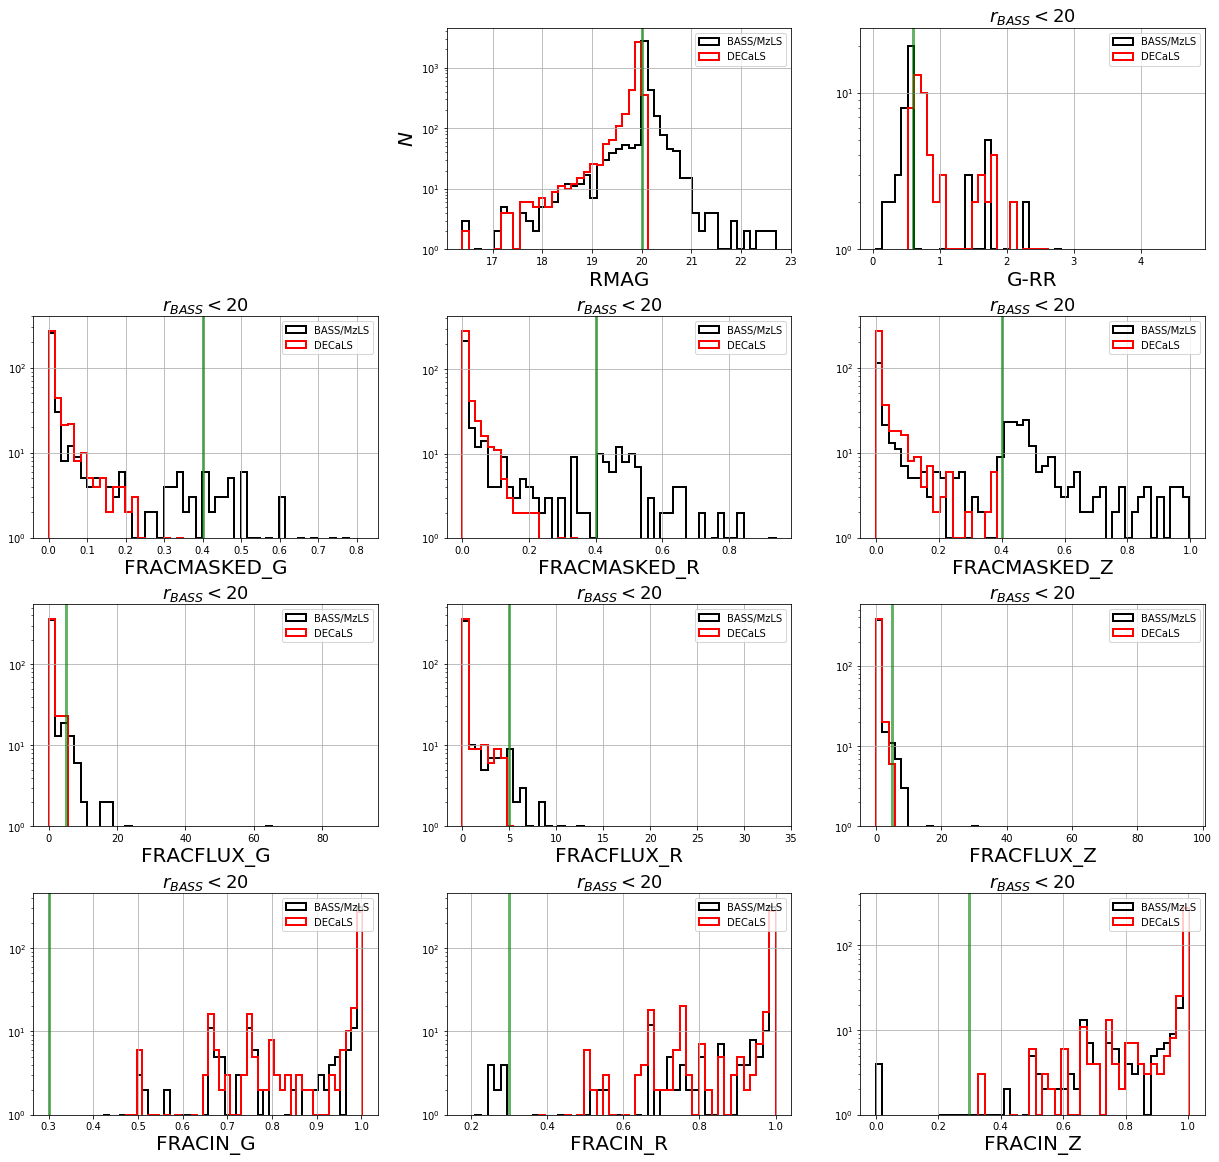

========== BGS in BASS/MzLS but not BGS in DECaLS (32.988 [1/sq.deg]) ==========


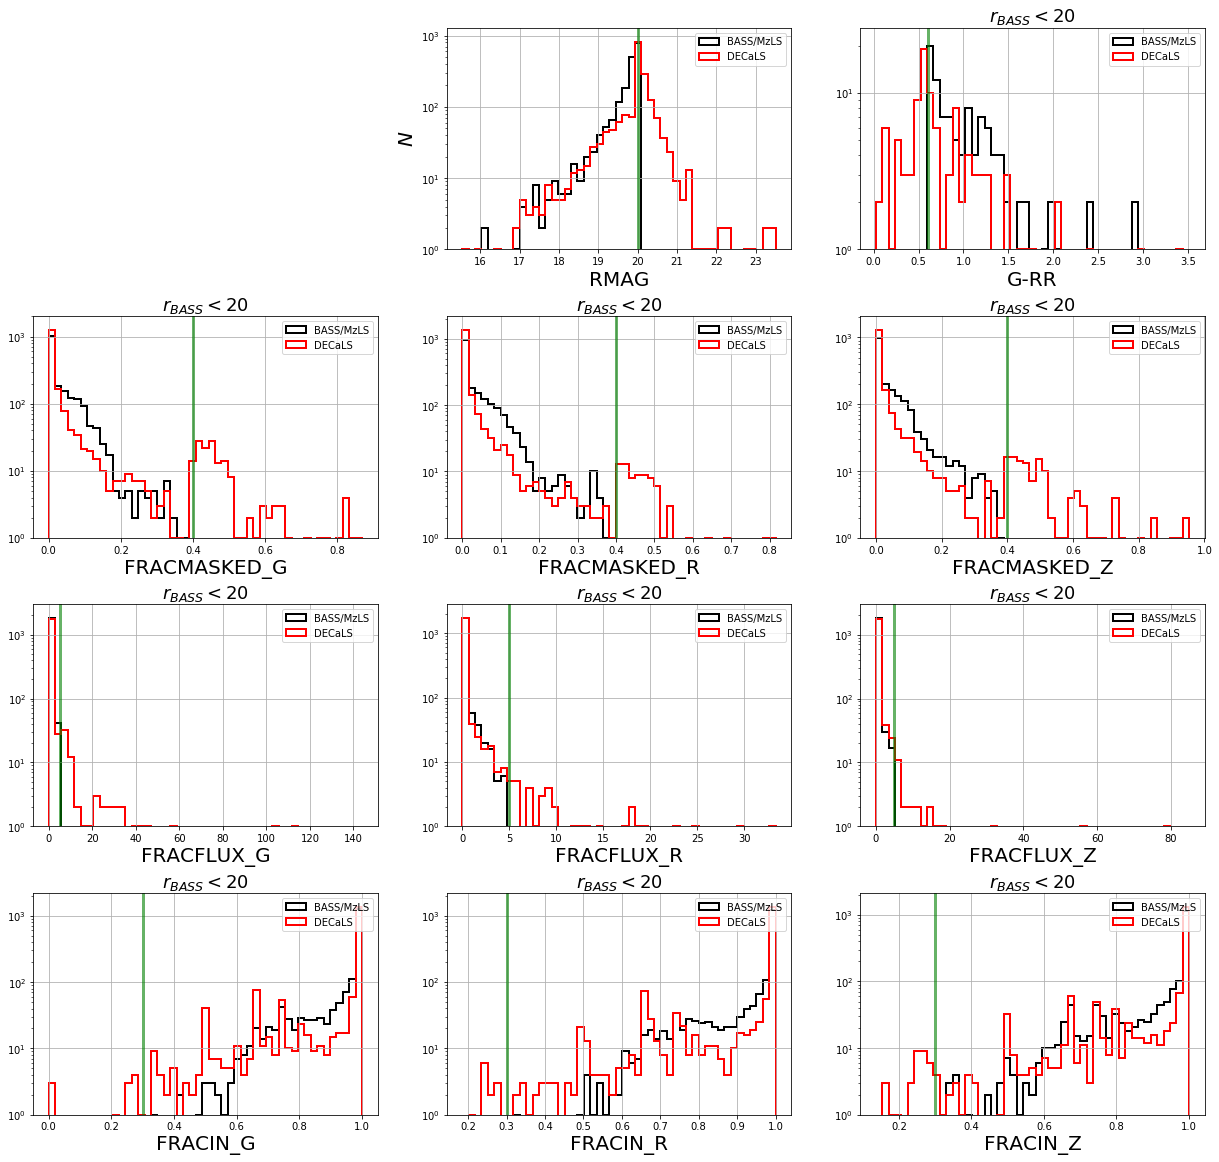

In [37]:
#
keep = {'BGS in DECaLS but not BGS in BASS/MzLS':(bgs_s) & (~bgs_n) & (nobs), 
        'BGS in BASS/MzLS but not BGS in DECaLS':(~bgs_s) & (bgs_n) & (nobs)}

for num, key, val in zip([0, 1],keep.keys(), keep.values()):
    
    print('========== %s (%.3f [1/sq.deg]) ==========' %(key, np.sum(val)/hpdict['redarea']))
    
    rows, cols = 4, 3
    fig    = plt.figure(figsize=(7*cols,5*rows))
    gs     = gridspec.GridSpec(rows, cols, hspace=0.3, wspace=0.20)
    
    plots = ['RMAG', 'G-RR', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 
             'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z']
    
    for num, plot in enumerate(plots):
        
        ax = fig.add_subplot(gs[num+1])
        
        if plot != 'RMAG': 
            val = (val) & (tab['RMAG_n'] < 20)
            ax.set_title(r'$r_{BASS} < 20$', size=18)
            
        if plot == 'G-RR':
            xn = Grr_n[(val) & (tab['G_n'] != 0) & (tab['G_s'] != 0)]
            xs = Grr_s[(val) & (tab['G_n'] != 0) & (tab['G_s'] != 0)]
        else:
            xn = tab[plot+'_n'][val]
            xs = tab[plot+'_s'][val]
        
        xn = xn[np.isfinite(xn)]
        xs = xs[np.isfinite(xs)]
        #print('%s north:\t %i' %(plot, len(xn)))
        #print('%s south:\t %i' %(plot, len(xs)))
        
        if plot == 'RMAG': vline = 20
        elif plot == 'G-RR': vline = 0.6
        elif plot[:10] == 'FRACMASKED': vline = 0.4
        elif plot[:8] == 'FRACFLUX': vline = 5.0
        elif plot[:6] == 'FRACIN': vline = 0.3
            
        xnlims = np.percentile(xn, (0.1, 99.9))
        xslims = np.percentile(xs, (0.1, 99.9))
        
        bins = np.linspace(np.min([xnlims[0], xslims[0]]), np.max([xnlims[1], xslims[1]]), 50)

        ax.hist(xn, bins=bins, histtype='step', lw=2, color='k', log=True, label='BASS/MzLS')
        ax.hist(xs, bins=bins, histtype='step', lw=2, color='r', log=True, label='DECaLS')
        ax.axvline(vline, lw=3, color='green', alpha=0.6)
        ax.set_xlabel(r'%s' %(plot), size=20)
        if num == 0: ax.set_ylabel(r'$N$', size=20)
        ax.legend()
        ax.grid()
        ax.set_ylim(1, None)
     
    file = pathdir+'/bgs_diff_%i' %(num)
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

    

# DEV ZONE...

In [144]:
plt.hist?

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=None,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    normed=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*.  The return value is a tuple
(*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
*patches1*,...]) if the input contains multiple data.  See the
documentation of the *weights* parameter to draw a histogram of
already-binned data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
